# Walkthrough of *keras*

This guide will go through the current neural net implementation as found in `functional_NN_EMG.py`. For more detailed information, the keras documentation found [here](https://keras.io/) is an invaluable resource.

## The Functional framework

There are two ways to write a neural network using keras. One is the Sequential framework (read more about it [here](https://keras.io/getting-started/sequential-model-guide/)). The second, more powerful and flexible framework, is the *functional* framework. Using it, many different kinds of neural networks can be written. The coding for it is pretty straightforward. In the most basic form, an output `y` is defined as a layer `LayerName` with parameters `param` applied to an input `x`:

`y = LayerName(params)(x)`

Let's take a look at an example:

`y = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid')(x)`

The output, `y`, will be the result of applying 16 different 3x3 filters to the input matrix x. In case the matrix shape is not perfectly divisible by a 3x3 matrix, no padding will be applied (use `padding='same'` for *keras* to apply zero padding to the input). See [here](https://github.com/vdumoulin/conv_arithmetic) for a visualization of how convolutions work with and without padding or [this](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t) stack overflow question for a quick example.

To then generate a new layer, simply pass `y` through a new layer like so:

`z = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid')(y)`

Now `z` is the output of running 16 3x3 filters through y. To keep things simpler, and not have too many variables, it is usually customary to build layers in the following manner. Let `x` be an input to a layer:

`x = Dropout(0.5)(x)`

In this way, the input `x` is overwritten with the output `x` which drops half of the features from the input (see [this](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) paper for much more detailed on why dropout is useful). In short, a dropout layer help to prevent the model from overfitting, which means that the model in essence ends up memorizing the training set and then being unable to generalize and make good predictions to data it has not seen before.

On the plus side, *keras* will automatically take care of any of the intermediate shapes. For keras, the only shape that has to be specified in the input shape. For detailed documentation, see [here](https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape) (though it is for the Sequential framework, but the same ideas hold). A couple of important caveats:
1. Input shape is specified as (rows, columns, channels) for 3D data. This means that a 1000x1000 RGB image input size would be (1000, 1000, 3). On the other hand, for a grayscale image (which only has one channel to describe a pixel value) would be (1000, 1000, 1). Note that the channel is important. Not specifiying the third channel would make keras think that the input size would be 1000 channels of a 1x1000 vector, rather than a single channel of a 1000x1000 matrix. This is **HUGELY** important for specifying layers in a neural net, and perhaps the greatest frustration in writing a neural network.
2. Some layers end up downsampling the input. For example, specifying a stride of (2, 2) in a 2D convolutional layer will result in an output whose size is halved with regards to both dimesions. I.e. an input of 1000x1000 will result in an output whose size is 500x500 if no padding is used. This is important if this layer is in parallel with a full-sized layer and the two layers are to be reconnected later.


## Let's take a look at an example

With this, I'll introduce the current framework. The network is a simplified version of the one from [here](https://stanfordmlgroup.github.io/projects/ecg/). The input is the [wavelet](https://en.wikipedia.org/wiki/Continuous_wavelet_transform)-transformed EMG data from each electrode of the Myoband. A parallel stream takes the root mean square of each channel. For more detail about any of the layers, the keras documentation is invaluable. This framework is far from perfect, getting approximately 80% accuracy for the 18 categories. But it's a good starting point for an example, and then you can implement and test your own changes. The full network implementation can be found in `functional_NN_EMG.py`. For the purposes of this file, ;et's just import the model underneath rather than going line-by-line.

To plot your own model, ensure that `pydot` is installed and you have installed `graphviz` from [here](https://www.graphviz.org/).

In [1]:
from functional_NN_EMG import define_NN_architecture

model = define_NN_architecture()

Using TensorFlow backend.


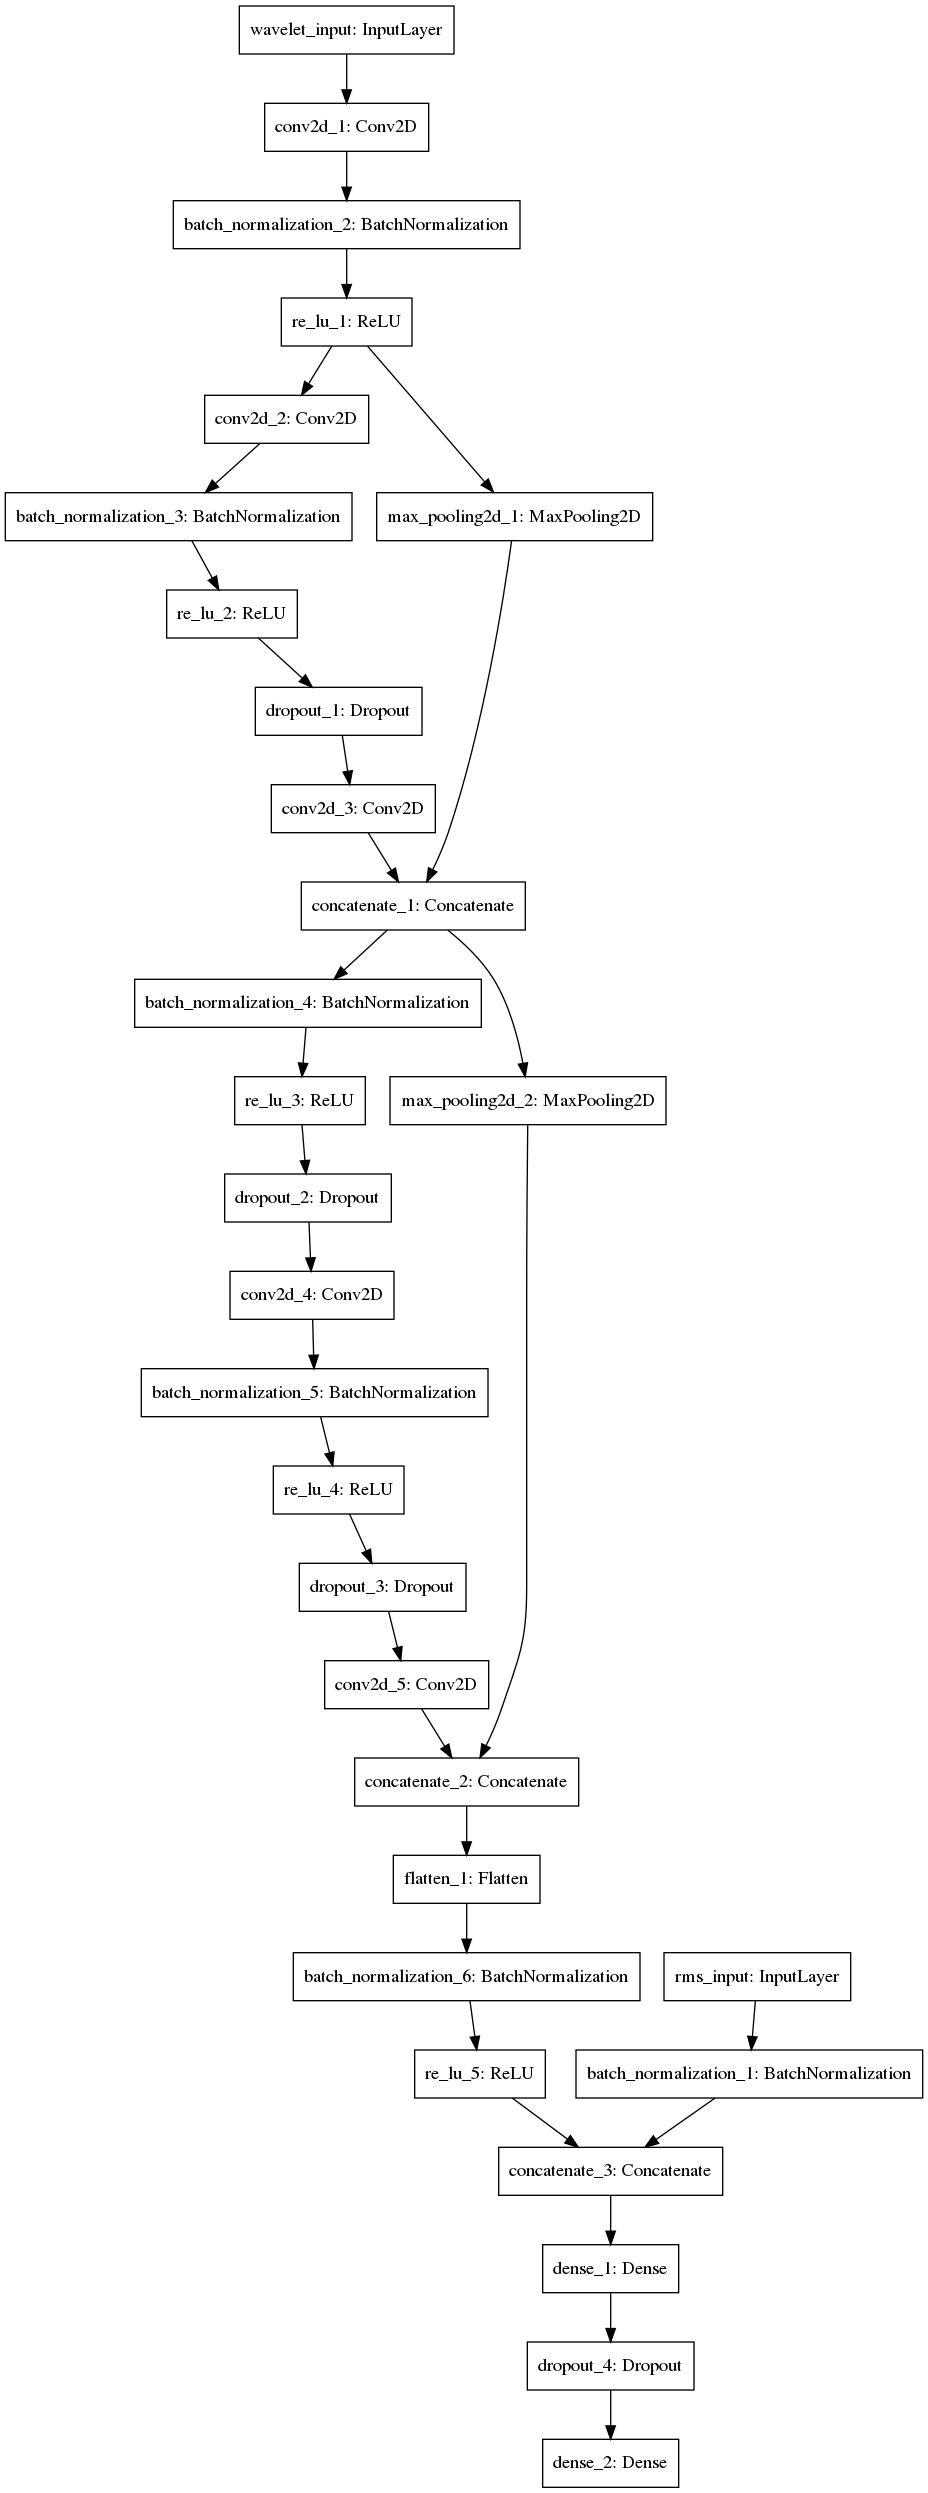

In [6]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model)
Image(filename='model.png')

And now for a summary of the model from the in-built summary command

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wavelet_input (InputLayer)      (None, 248, 16, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 248, 16, 32)  320         wavelet_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 248, 16, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 248, 16, 32)  0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Thus even this fairly simple model itself has nearly 3 **M**illion parameters to optimize.